In [64]:
from torch.utils.data import DataLoader
from Network.Mobilenet import MobileNet
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
import torch
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors as mcolors
from tqdm import tqdm
from torch import nn, int32, int64, float32, save
from torchmetrics import Accuracy, F1Score

#python main.py -v FedRefMNIST -m fedref -t mnist -e 4 --lr 4e-3 -bs 64 -r 100 -d None -cd None --lda 0.01 --prime 5
#python main.py -v FedAvgMNIST -m fedavg -t mnist -e 4 --lr 4e-3 -bs 64 -r 100 -d None -cd None 

In [65]:
def ploting(fedavg, fedprox, fedref, title="MNIST Classification", zoom_min = 20, zoom_max=25, inset=True):
    # 예시 데이터
    tableau_colors = list(mcolors.TABLEAU_COLORS.values())
    
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(fedavg["loss"], marker=".",linestyle="--",label="fedavg", color=tableau_colors[0], alpha=1)
    ax.plot(fedprox["loss"], marker=".", linestyle="--" ,label="fedprox(mu=0.5)", color=tableau_colors[1], alpha=0.7)
    for i,l in enumerate(fedref):
        ax.plot(l["loss"], marker=".", label=l["label"], color=tableau_colors[i+2], linestyle="--")

    # 메인 축 설정
    ax.set_title(title)
    ax.set_xlabel("Round")
    ax.set_ylabel("Loss")
    ax.legend()
    # 🔍 확대 구간 설정 (마지막 x값 근처, 예: x > 90)
    x_zoom_min = zoom_min
    x_zoom_max = zoom_max

    # inset 축 생성
    if inset:
        axins = inset_axes(ax, width="30%", height="40%", loc='lower right')
        axins.plot(fedavg["loss"], color =tableau_colors[0], label = "fedavg", marker=".", alpha=1, linestyle="--")
        axins.plot(fedprox["loss"], color =tableau_colors[1], label = "fedprox", linestyle="--", marker= ".", alpha=0.7)
        for i,l in enumerate(fedref):
            axins.plot(l["loss"], label=l["label"], color=tableau_colors[i+2], linestyle="--", marker=".")
            
        alp = fedavg["loss"][zoom_min:zoom_max+1].to_list() + fedprox["loss"][zoom_min:zoom_max+1].to_list()
        for l in fedref:
            alp = alp + l["loss"][zoom_min:zoom_max+1].to_list()
        
        axins.set_xlim(x_zoom_min, x_zoom_max)
        #확대된 y축 범위도 지정하면 보기 쉬움
        #y_zoom = y[(x >= x_zoom_min) & (x <= x_zoom_max)]
        axins.set_ylim(bottom=min(alp), top = max(alp))
        
        # 확대된 영역 표시선 연결
        ax.indicate_inset_zoom(axins)
    ax.legend(fontsize=11, loc="lower left")
    
    minimum = [fedavg["loss"].min(), fedprox["loss"].min()] + [ s["loss"].min() for s in fedref]
    minimum = min(minimum)
    ax.set_ylim(bottom=minimum, top=fedavg["loss"].max())
    fig.show()
    

C:\Users\tyoon\AppData\Local\Temp\ipykernel_26336\3321155132.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


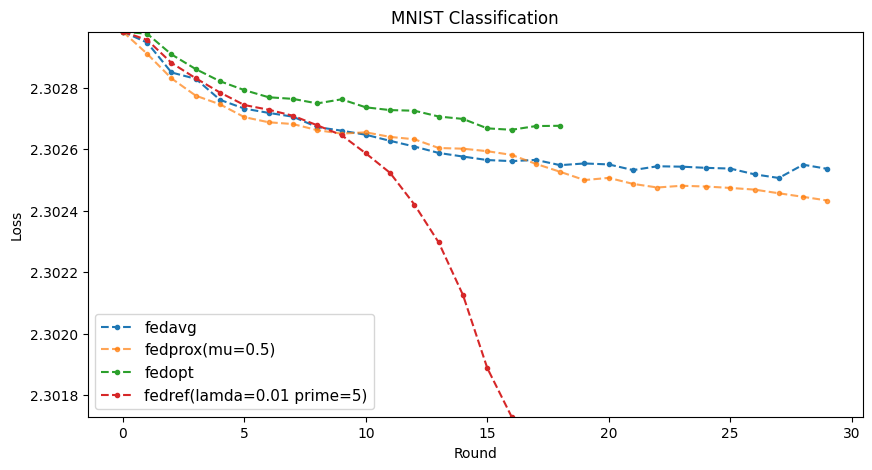

In [ ]:
fedavg = pd.read_csv("Result/fedavg/fedavg_mnist.csv")
fedprox = pd.read_csv("Result/fedprox/fedprox_mnist.csv")
# fedadam = pd.read_csv("Result/fedadam/fedadam_mnist.csv")
# fedadagrad = pd.read_csv("Result/fedadagrad/fedadagrad_mnist.csv")
# fedyogi = pd.read_csv("Result/fedyogi/fedyogi_mnist.csv")
fedopt = pd.read_csv(("Result/fedopt/fedopt_mnist.csv"))
# fedref1 = pd.read_csv("Result/fedref/FedRef_mnist_lda0.04_p5.csv")
fedref = pd.read_csv("Result/fedref/fedref_mnist_lda0.1_p5.csv")
fedref2 = pd.read_csv("Result/fedref/fedref_mnist_lda0.001_p5.csv")
# fedref4 = pd.read_csv("Result/fedref/FedRef_mnist_lda1.0_p2.csv")
# ploting(fedavg, fedprox, ({"loss":fedopt["loss"], "label": "fedopt"},
#                             {"loss":fedref1["loss"], "label":"fedref(lamda=0.9 prime=5)"},
#                             {"loss":fedref2["loss"], "label": "fedref(lamda=0.01 prime=5)"},
#                             {"loss":fedref3["loss"], "label": "fedref(lamda=0.1 prime=5)"},
#                             {"loss":fedref4["loss"], "label":"fedref(lamda=0.1 prime=2)"},
#                             ), zoom_min=70, zoom_max=100, title="MNIST Classification")
ploting(fedavg[:30], fedprox[:30], (
#                          {"loss":fedadam["loss"], "label": "fedadam"} ,
#                          {"loss":fedadagrad["loss"], "label":"fedadagrad"},
#                          {"loss":fedyogi["loss"], "label":"fedyogi"},                         
                          {"loss":fedopt["loss"], "label": "fedopt"} ,
                          {"loss":fedref["loss"][:18], "label": "fedref(lamda=0.01 prime=5)"},
                          {"loss":fedref["loss"], "label": "fedref(lamda=0.0001 prime=5)"},
        ), zoom_min=8, zoom_max=17, title="MNIST Classification", inset=False)

In [3]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainset = datasets.MNIST("./Data", True, Compose([ToTensor(), Resize((64,64))]), None, True)
testset = datasets.MNIST("./Data", False, Compose([ToTensor(), Resize((64,64))]), None, True)
loader = DataLoader(trainset, 64, shuffle=True, collate_fn=lambda x:x)
tloader = DataLoader(testset, 64, shuffle=True, collate_fn=lambda x:x)
lossf = torch.nn.CrossEntropyLoss().to(DEVICE)
net = MobileNet(outdim=10)
optim = torch.optim.SGD(net.parameters(), lr=4e-3)

In [13]:
def valid(net, valid_loader, e, lossf, DEVICE, Central=False):
    net.eval()
    Dicenary = {'accuracy':0, 'f1score':0}
    length = len(valid_loader) 
    losses = 0
    accf = Accuracy("multiclass", num_classes=10, multidim_average="global").to(DEVICE)
    f1scoref = F1Score("multiclass", num_classes=10, multidim_average="global", threshold=0.7).to(DEVICE)
    for sample in tqdm(valid_loader, desc="Validation: "):
    
        X= torch.stack([s[0] for s in sample], 0)
        Y= torch.Tensor([s[1] for s in sample])
        if len(sample) != 1:
            out = net(torch.stack([X.type(float32),X.type(float32),X.type(float32)], 1).to(DEVICE).squeeze()) 
            losses += lossf(out.type(float32).to(DEVICE), Y.type(int64).to(DEVICE)).item()
        else:
            out = net(torch.stack([X.type(float32),X.type(float32),X.type(float32)], 1).to(DEVICE).squeeze().unsqueeze(0)) 
            losses += lossf(out.type(float32).to(DEVICE), Y.type(int64).to(DEVICE)).item()
        out = out.softmax(dim=1)
        Dicenary[f"accuracy"] += accf(out.type(float32).to(DEVICE), Y.type(int64).to(DEVICE)).item()
        Dicenary[f"f1score"] += f1scoref(out.type(float32).to(DEVICE), Y.type(int64).to(DEVICE)).item()

    # if Central:
        # logger.info(f"Result epoch {e+1}: loss:{losses/length} accuracy: {Dicenary["accuracy"]/length: .4f} f1score: {Dicenary["f1score"]/length: .4f}")
        
    # return {"loss":losses/length, 'accuracy': Dicenary["accuracy"] , "f1score":Dicenary["f1score"]}
    return {"loss": losses/length , "accuracy": Dicenary["accuracy"]/length, "f1score": Dicenary["f1score"]/length}

In [14]:
net.load_state_dict(torch.load("Models/FedAvgMNIST/net.pt"))
valid(net.to(DEVICE), tloader, 1, lossf, DEVICE, False)

Validation: 100%|██████████| 157/157 [00:03<00:00, 46.83it/s]


{'loss': 2.3025568032720285,
 'accuracy': 0.11355493630573249,
 'f1score': 0.11355493630573249}

In [15]:
net.load_state_dict(torch.load("Models/FedProxMNIST/net.pt"))
valid(net.to(DEVICE), tloader, 1, lossf, DEVICE, False)

Validation: 100%|██████████| 157/157 [00:03<00:00, 48.92it/s]


{'loss': 2.3025027111077763,
 'accuracy': 0.10290605095541401,
 'f1score': 0.10290605095541401}